# Установка зависимостей и импорты

In [45]:
import os
import json
import time
import random
import shutil
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.ops import box_convert
from torchinfo import summary
import albumentations as A

In [46]:
# Скачиваем torchvision references (нужны для движка обучения)
!git clone https://github.com/pytorch/vision.git /tmp/vision

import sys
sys.path.insert(0, '/tmp/vision/references/detection')

# Импорты из скачанного репозитория torchvision
from engine import train_one_epoch, evaluate
import utils

fatal: destination path '/tmp/vision' already exists and is not an empty directory.


In [47]:
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Not Available'}")

✓ PyTorch: 2.8.0+cu126
✓ GPU: Tesla P100-PCIE-16GB


In [48]:
# Настройка путей Kaggle
DATA_ROOT = Path("/kaggle/input/leapgestrecog/leapGestRecog") 

# Kaggle Working (Write Access)
WORK_DIR = Path("/kaggle/working")
OUT_ROOT = WORK_DIR / "leapgest_coco"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

print(f"✓ DATA_ROOT: {DATA_ROOT}")
print(f"✓ WORK_DIR: {WORK_DIR}")

✓ DATA_ROOT: /kaggle/input/leapgestrecog/leapGestRecog
✓ WORK_DIR: /kaggle/working


In [49]:
# Конфигурация
class CFG:
    TRAIN_JSON = OUT_ROOT/"annotations_train.json"
    VAL_JSON   = OUT_ROOT/"annotations_val.json"
    TEST_JSON  = OUT_ROOT/"annotations_test.json"
    NUM_EPOCHS = 15
    BATCH_SIZE = 8
    LR = 1e-4
    NUM_WORKERS = 2
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [50]:
cfg = CFG()

# Подготовка данных и генерация COCO аннотаций

In [51]:
GESTURE_NAMES = ["palm", "l", "fist", "fist_moved", "thumb",
                 "index", "ok", "palm_moved", "c", "down"]
CLASS_NAMES = [f"{i+1:02d}_{name}" for i, name in enumerate(GESTURE_NAMES)]
categories = [{"id": i+1, "name": cls} for i, cls in enumerate(CLASS_NAMES)]

In [52]:
# Сплит по субъектам
train_subjects = [f"{i:02d}" for i in range(7)]    # 00-06
val_subjects   = ["07", "08"]
test_subjects  = ["09"]

In [53]:
def collect_images(data_root: Path):
    splits = {"train": [], "val": [], "test": []}
    
    # Проход по всем папкам (00-09)
    for subj_dir in sorted(data_root.glob("*")):
        if not subj_dir.is_dir(): continue
        subj = subj_dir.name
        for gesture_dir in sorted(subj_dir.glob("*")):
            if not gesture_dir.is_dir(): continue
            gesture_name = gesture_dir.name
            try:
                # Извлекаем ID жеста из названия папки (например "01_palm" -> 0)
                gesture_id = int(gesture_name.split("_")[0]) - 1
            except:
                continue
            for img_path in gesture_dir.glob("*.png"):
                item = {
                    "path": img_path,
                    "subject": subj,
                    "gesture_id": gesture_id,
                    "gesture_name": gesture_name
                }
                if subj in train_subjects: splits["train"].append(item)
                elif subj in val_subjects: splits["val"].append(item)
                elif subj in test_subjects: splits["test"].append(item)
    return splits

In [54]:
splits = collect_images(DATA_ROOT)
print(f"Train: {len(splits['train'])}, Val: {len(splits['val'])}, Test: {len(splits['test'])}")

Train: 14000, Val: 4000, Test: 2000


In [55]:
def build_coco(items, categories, out_json):
    images, annotations = [], []
    ann_id = 1
    for img_id, item in enumerate(tqdm(items, desc=out_json.name), start=1):
        img_path = item["path"]
        # Читаем размеры изображения (обычно 640x240 для этого датасета, но проверим)
        with Image.open(img_path) as im:
            w, h = im.size
            
        # Псевдо-bbox: весь кадр
        bbox = [0.0, 0.0, float(w), float(h)]
        cat_id = item["gesture_id"] + 1
        images.append({
            "id": img_id,
            "file_name": str(img_path), # Храним полный путь для простоты
            "width": w,
            "height": h
        })
        annotations.append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": cat_id,
            "bbox": bbox,
            "area": bbox[2] * bbox[3],
            "iscrowd": 0
        })
        ann_id += 1
    coco = {"images": images, "annotations": annotations, "categories": categories}
    with open(out_json, "w") as f:
        json.dump(coco, f, indent=2)

In [56]:
# Создаем JSON файлы в рабочей директории
build_coco(splits["train"], categories, OUT_ROOT/"annotations_train.json")
build_coco(splits["val"],   categories, OUT_ROOT/"annotations_val.json")
build_coco(splits["test"],  categories, OUT_ROOT/"annotations_test.json")

annotations_train.json:   0%|          | 0/14000 [00:00<?, ?it/s]

annotations_val.json:   0%|          | 0/4000 [00:00<?, ?it/s]

annotations_test.json:   0%|          | 0/2000 [00:00<?, ?it/s]

# Dataset и Dataloaders

In [57]:
# Аугментации
train_tf = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

val_tf = A.Compose([], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

/tmp/ipykernel_55/3438876490.py:8: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [58]:
class CocoDetDataset(Dataset):
    def __init__(self, ann_path, tfm=None):
        self.tfm = tfm
        with open(ann_path) as f:
            coco = json.load(f)
        self.images = coco["images"]
        self.ann_by_img = {img["id"]: [] for img in self.images}
        for ann in coco["annotations"]:
            self.ann_by_img[ann["image_id"]].append(ann)
        self.cat_id_to_idx = {c["id"]: i+1 for i,c in enumerate(coco["categories"])}
        self.class_names = ["__background__"] + [c["name"] for c in coco["categories"]]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        info = self.images[idx]
        img_path = Path(info["file_name"]) # Путь уже полный
        img = np.array(Image.open(img_path).convert("RGB"))
        anns = self.ann_by_img[info["id"]]

        boxes, labels, areas, iscrowd = [], [], [], []
        for a in anns:
            x,y,w,h = a["bbox"]
            boxes.append([x,y,w,h])
            labels.append(self.cat_id_to_idx[a["category_id"]])
            areas.append(a.get("area", w*h))
            iscrowd.append(a.get("iscrowd", 0))

        if self.tfm:
            out = self.tfm(image=img, bboxes=boxes, category_id=labels)
            img = out["image"]
            boxes = out["bboxes"]
            labels = out["category_id"]

        # Конвертация в тензоры
        if len(boxes) == 0:
            boxes_xyxy = torch.zeros((0,4), dtype=torch.float32)
            labels_t = torch.zeros((0,), dtype=torch.int64)
            areas_t = torch.zeros((0,), dtype=torch.float32)
            iscrowd_t = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes_xyxy = box_convert(torch.tensor(boxes, dtype=torch.float32), in_fmt="xywh", out_fmt="xyxy")
            labels_t = torch.tensor(labels, dtype=torch.int64)
            areas_t = torch.tensor(areas, dtype=torch.float32)
            iscrowd_t = torch.tensor(iscrowd, dtype=torch.int64)

        img_t = F.to_tensor(img)
        target = {
            "boxes": boxes_xyxy, "labels": labels_t,
            "image_id": info["id"], "area": areas_t, "iscrowd": iscrowd_t
        }
        return img_t, target

In [59]:
def collate_fn(batch):
    imgs, targets = list(zip(*batch))
    return list(imgs), list(targets)

In [60]:
train_ds = CocoDetDataset(cfg.TRAIN_JSON, tfm=train_tf)
val_ds   = CocoDetDataset(cfg.VAL_JSON, tfm=val_tf)

train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, 
                          num_workers=cfg.NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, 
                          num_workers=cfg.NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)

print("✓ DataLoaders готовы")

✓ DataLoaders готовы


# Модель и Обучение

In [61]:
def build_model(num_classes):
    # MobileNetV3 Large вместо ResNet50
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
        weights="DEFAULT",
        min_size=240,
        max_size=640
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes)
    return model

In [62]:
model = build_model(len(train_ds.class_names)).to(cfg.DEVICE)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=cfg.LR, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [63]:
best_map = 0.0
history = {"train_loss": [], "val_map": [], "lr": []}
for epoch in range(cfg.NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{cfg.NUM_EPOCHS} ---")
    
    metric_logger = train_one_epoch(model, optimizer, train_loader, cfg.DEVICE, epoch, print_freq=100)
    train_loss = metric_logger.meters['loss'].global_avg
    history["train_loss"].append(train_loss)
    
    coco_evaluator = evaluate(model, val_loader, device=cfg.DEVICE)
    val_map = coco_evaluator.coco_eval["bbox"].stats[0]
    history["val_map"].append(val_map)
    
    lr_scheduler.step(val_map)
    current_lr = optimizer.param_groups[0]['lr']
    history["lr"].append(current_lr)
    
    if val_map > best_map:
        best_map = val_map
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✓ Saved Best Model: mAP={val_map:.4f}")

print(f"Training Complete. Best mAP: {best_map:.4f}")


--- Epoch 1/15 ---
Epoch: [0]  [   0/1750]  eta: 0:13:34  lr: 0.000000  loss: 3.1265 (3.1265)  loss_classifier: 2.4669 (2.4669)  loss_box_reg: 0.2431 (0.2431)  loss_objectness: 0.4035 (0.4035)  loss_rpn_box_reg: 0.0130 (0.0130)  time: 0.4656  data: 0.2624  max mem: 6354
Epoch: [0]  [ 100/1750]  eta: 0:03:16  lr: 0.000010  loss: 2.3559 (2.8447)  loss_classifier: 1.8012 (2.2069)  loss_box_reg: 0.4552 (0.3672)  loss_objectness: 0.1264 (0.2568)  loss_rpn_box_reg: 0.0140 (0.0139)  time: 0.1136  data: 0.0004  max mem: 6354
Epoch: [0]  [ 200/1750]  eta: 0:02:57  lr: 0.000020  loss: 1.9448 (2.4182)  loss_classifier: 0.9801 (1.6907)  loss_box_reg: 0.9278 (0.5595)  loss_objectness: 0.0179 (0.1541)  loss_rpn_box_reg: 0.0118 (0.0140)  time: 0.1067  data: 0.0005  max mem: 6354
Epoch: [0]  [ 300/1750]  eta: 0:02:43  lr: 0.000030  loss: 2.3743 (2.3867)  loss_classifier: 1.1331 (1.4995)  loss_box_reg: 1.2299 (0.7685)  loss_objectness: 0.0072 (0.1065)  loss_rpn_box_reg: 0.0069 (0.0121)  time: 0.1121  

# Визуализация результатов (Графики)

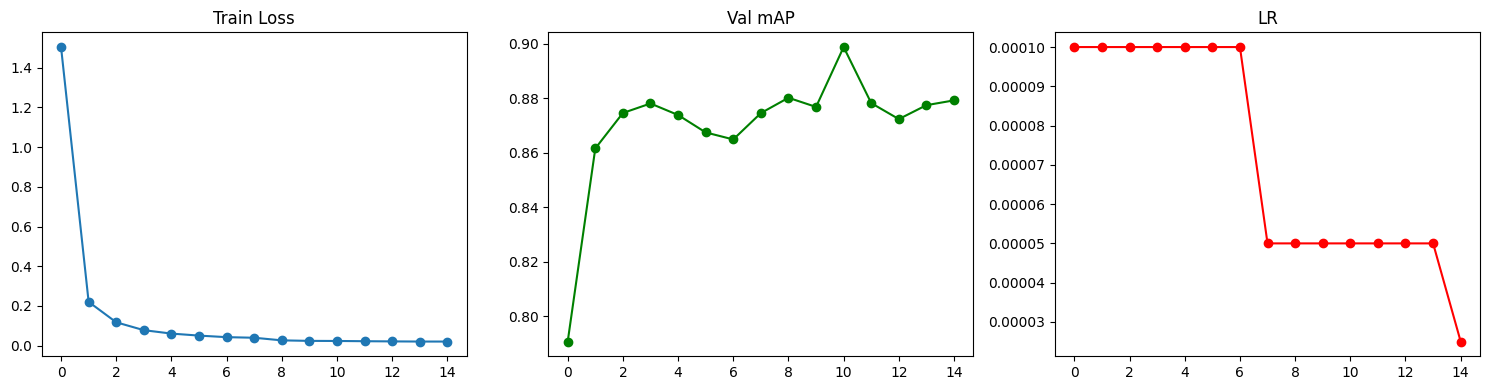

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].plot(history["train_loss"], marker='o'); axes[0].set_title("Train Loss")
axes[1].plot(history["val_map"], marker='o', color='green'); axes[1].set_title("Val mAP")
axes[2].plot(history["lr"], marker='o', color='red'); axes[2].set_title("LR")
plt.tight_layout()
plt.show()

# Тестирование и Визуализация предиктов

In [65]:
# Загрузка лучшей модели
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(240,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [66]:
# Функция для отображения (cv2.imshow не работает в Kaggle Notebooks, используем plt)
def visualize_prediction(model, img_path, class_names, conf_th=0.5):
    img = Image.open(img_path).convert("RGB")
    img_t = F.to_tensor(img).to(cfg.DEVICE)
    with torch.no_grad():
        out = model([img_t])[0]
    keep = out["scores"] > conf_th
    boxes = out["boxes"][keep].cpu().numpy()
    labels = out["labels"][keep].cpu().numpy()
    scores = out["scores"][keep].cpu().numpy()
    img_cv = np.array(img).copy()
    for b, l, s in zip(boxes, labels, scores):
        x1, y1, x2, y2 = map(int, b)
        cv2.rectangle(img_cv, (x1,y1), (x2,y2), (0,255,0), 2)
        text = f"{class_names[l]}: {s:.2f}"
        cv2.putText(img_cv, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)     
    plt.figure(figsize=(8,6))
    plt.imshow(img_cv)
    plt.axis('off')
    plt.show()

Test Sample: 01_palm


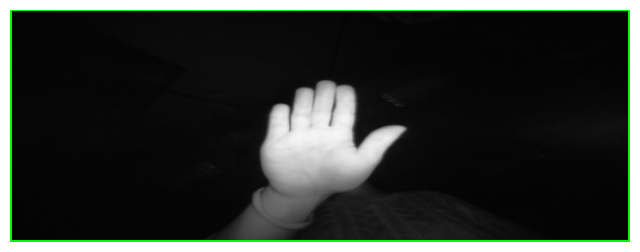

In [67]:
# Пример на тестовых данных
sample = random.choice(splits["test"])
print(f"Test Sample: {sample['gesture_name']}")
visualize_prediction(model, sample["path"], train_ds.class_names)

# Генерация Видео (Инференс)

In [68]:
# Вместо интерактивного просмотра, создадим видеофайл
def create_inference_video(model, items, out_name="output.mp4", fps=10):
    model.eval()
    frame_size = (320, 240) # Подгоняем под размер изображений
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_writer = cv2.VideoWriter(out_name, fourcc, fps, frame_size)
    print(f"Generating video: {out_name}...")
    for item in tqdm(items):
        img = cv2.imread(str(item["path"]))
        if img is None: continue
        img = cv2.resize(img, frame_size)
        
        # Инференс
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tensor = F.to_tensor(img_rgb).to(cfg.DEVICE)
        with torch.no_grad():
            res = model([tensor])[0]
        keep = res["scores"] > 0.5
        boxes = res["boxes"][keep].cpu().numpy()
        labels = res["labels"][keep].cpu().numpy()
        scores = res["scores"][keep].cpu().numpy()
        for b, l, s in zip(boxes, labels, scores):
            x1, y1, x2, y2 = map(int, b)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
            label = f"{train_ds.class_names[l].split('_')[-1]}:{s:.2f}"
            cv2.putText(img, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
        out_writer.write(img)
    out_writer.release()
    print("✓ Видео сохранено.")

In [69]:
# Берем 100 случайных кадров из теста
test_subset = random.sample(splits["test"], 100)
create_inference_video(model, test_subset, "kaggle_demo_video.mp4")

Generating video: kaggle_demo_video.mp4...


  0%|          | 0/100 [00:00<?, ?it/s]

✓ Видео сохранено.
